In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
from matplotlib.transforms import IdentityTransform, TransformedBbox, Bbox

In [2]:
class AngleAnnotation(Arc):
    """
    draws an arc between two vectors which appears circular in display space
    """
    def __init__(
        self, xy, p1, p2, size=75, unit="points", ax=None,
        text="", textposition="inside", text_kw=None, **kwargs,
    ):
        """
        Parameters
        ----------
        xy, p1, p2 : tuple or array of two floats
            Center position and two points. Angle annotation is drawn between
            the two vectors connecting *p1* and *p2* with *xy*, respectively.
            Units are data coordinates.
        
        size : float
            Diameter of the angle annotation in units specified by *unit*.
        
        unit : str
            One of the following strings to specify the unit of *size*:
            
            * "pixels": pixels
            * "points": points, use points instead of pixels to not have a
                dependence on the DPI
            * "axes width", "axes height": relative units of Axes width, height
            * "axes min", "axes max": minimum or maximum of relative Axes
                width, height
        
        ax : `matplotlib.axes.Axes`
            The Axes to add the angle annotation to.
        
        text : str
            The text to mark the angle with.
        
        textposition : {"inside", "outside", "edge"}
            Whether to show the text in- or outside the arc. "edge" can be used
            for custom positions anchored at the arc's edge.
        
        text_kw : dict
            Dictionary of arguments passed to the Annotation.
        
        **kwargs
            Further parameters are passed to `matplotlib.patches.Arc`. Use this
            to specify, color, linewidth etc. of the arc.
        """
        self.ax = ax or plt.gca()
        self._xydata = xy # in data coordinates
        self.vec1 = p1
        self.vec2 = p2
        self.size = size
        self.unit = unit
        self.textposition = textposition
        
        super().__init__(
            self._xydata, size, size, angle=0.0,
            theta1=self.theta1, theta2=self.theta2, **kwargs,
        )
        
        self.set_transform(IdentityTransform())
        self.ax.add_patch(self)
        
        self.kw = {
            "ha": "center", "va": "center", "xycoords": IdentityTransform(),
            "xytext": (0, 0), "textcoords": "offset points", "annotation_clip": True,
        }
        self.kw.update(text_kw or {})
        self.text = ax.annotate(text, xy=self._center, **self.kw)
    
    def get_size(self):
        factor = 1.0
        if self.unit == "points":
            factor = self.ax.figure.dpi / 72.0
        elif self.unit[:4] == "axes":
            b = TransformedBbox(Bbox.unit(), self.ax.transAxes)
            dic = {
                "max": max(b.width, b.height),
                "min": min(b.width, b.height),
                "width": b.width, "height": b.height,
            }
            factor = dic[self.unit[5:]]
        return self.size * factor
    
    def set_size(self, size):
        self.size = size
    
    def get_center_in_pixels(self):
        """return center in pixels"""
        return self.ax.transData.transform(self._xydata)
    
    def set_center(self, xy):
        """set center in data coordinates"""
        self._xydata = xy
    
    def get_theta(self, vec):
        vec_in_pixels = self.ax.transData.transform(vec) - self._center
        return np.rad2deg(np.arctan2(vec_in_pixels[1], vec_in_pixels[0]))
    
    def get_theta1(self):
        return self.get_theta(self.vec1)
    
    def get_theta2(self):
        return self.get_theta(self.vec2)
    
    def set_theta(self, angle):
        pass
    
    # redefine attributes of the Arc to always give values in pixel space
    _center = property(get_center_in_pixels, set_center)
    theta1 = property(get_theta1, set_theta)
    theta2 = property(get_theta2, set_theta)
    width = property(get_size, set_size)
    height = property(get_size, set_size)
    
    # the following two methods are needed to update the text position
    def draw(self, renderer):
        self.update_text()
        super().draw(renderer)
    
    def update_text(self):
        c = self._center
        s = self.get_size()
        angle_span = (self.theta2 - self.theta1) % 360
        angle = np.deg2rad(self.theta1 + angle_span / 2)
        r = s / 2
        
        if self.textposition == "inside":
            r = s / np.interp(angle_span, [60, 90, 135, 180], [3.3, 3.5, 3.8, 4])
        
        self.text.xy = c + r * np.array([np.cos(angle), np.sin(angle)])
        if self.textposition == "outside":
            def R90(a, r, w, h):
                if a < np.arctan(h / 2 / (r + w / 2)):
                    return np.sqrt((r + w / 2) ** 2 + (np.tan(a) * (r + w / 2)) ** 2)
                else:
                    c = np.sqrt((w / 2) ** 2 + (h / 2) ** 2)
                    t = np.arcsin(c * np.cos(np.pi / 2 - a + np.arcsin(h / 2 / c)) / r)
                    xy = r * np.array([np.cos(a + t), np.sin(a + t)])
                    xy += np.array([w / 2, h / 2])
                    return np.sqrt(np.sum(xy ** 2))
            
            def R(a, r, w, h):
                aa = (a % (np.pi / 4)) * ((a % (np.pi / 2)) <= np.pi / 4) + \
                    (np.pi / 4 - (a % (np.pi / 4))) * ((a % (np.pi / 2)) >= np.pi / 4)
                return R90(aa, r, *[w, h][::int(np.sign(np.cos(2 * a)))])
            
            bbox = self.text.get_window_extent()
            x = R(angle, r, bbox.width, bbox.height)
            trans = self.ax.figure.dpi_scale_trans.inverted()
            offs = trans.transform(((x - s / 2), 0))[0] * 72
            self.text.set_position([offs * np.cos(angle), offs * np.sin(angle)])

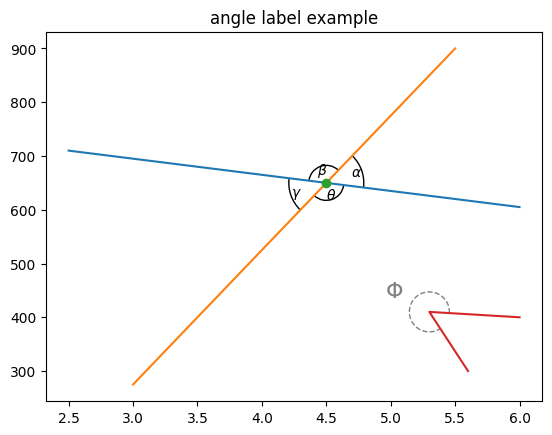

In [3]:
fig, ax = plt.subplots()
fig.canvas.draw() # need to draw the figure to define renderer
ax.set_title("angle label example")

# plot two crossing lines and label each angle between them with the above ``AngleAnnotation`` tool
center = (4.5, 650)
p1 = [(2.5, 710), (6.0, 605)]
p2 = [(3.0, 275), (5.5, 900)]
line1 = ax.plot(*zip(*p1))
line2 = ax.plot(*zip(*p2))
point, = ax.plot(*center, marker="o")

am1 = AngleAnnotation(center, p1[1], p2[1], ax=ax, size=75, text=r"$\alpha$")
am2 = AngleAnnotation(center, p2[1], p1[0], ax=ax, size=35, text=r"$\beta$")
am3 = AngleAnnotation(center, p1[0], p2[0], ax=ax, size=75, text=r"$\gamma$")
am4 = AngleAnnotation(center, p2[0], p1[1], ax=ax, size=35, text=r"$\theta$")

# showcase some styling options for the angle arc, as well as the text
p = [(6.0, 400), (5.3, 410), (5.6, 300)]
ax.plot(*zip(*p))
am5 = AngleAnnotation(
    p[1], p[0], p[2], ax=ax, size=40, text=r"$\Phi$", linestyle="--", color="gray",
    textposition="outside", text_kw={"fontsize": 16, "color": "gray"},
)

plt.show()